In [1]:
import spacy
from keras.applications.vgg16 import VGG16
from keras.applications.inception_resnet_v2 import InceptionResNetV2
import matplotlib.pyplot as plt
from keras.utils import plot_model,multi_gpu_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.models import Model
from keras.models import load_model
from keras.layers import Input,GlobalAveragePooling2D,Layer,InputSpec
from keras.layers.core import Dense,Flatten,Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras.utils import np_utils
import keras.backend as K
import keras.layers as kl
from keras.preprocessing import sequence
import tensorflow as tf
from tensorflow.python.client import device_lib
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np
from time import time
import pickle
# from AttentionModule import SelfAttention, SoftAttention
import os
os.environ["CUDA_VISIBLE_DEVICES"]='0'
import cv2
from tqdm import tqdm_notebook
from tqdm import tqdm
from AttentionMed import SelfAttention, Attention
# from coord import CoordinateChannel2D

Using TensorFlow backend.


In [2]:
n_gpu=1
n_cpu=1
tf_config= tf.ConfigProto(device_count = {'GPU': n_gpu , 'CPU': n_cpu})
tf_config.gpu_options.allow_growth=True
s=tf.Session(config=tf_config)
K.set_session(s)

In [3]:
nlp = spacy.load('en_core_web_md')

In [4]:
path=os.getcwd() #Get the path
path

'/media/MyDataStor1/mshaikh2/project_xray/notebooks'

In [5]:
proj_ds=pd.read_csv(path+'/../dataset/indiana_projections.csv')
repo_ds=pd.read_csv(path+'/../dataset/indiana_reports.csv')

display(proj_ds.head(50),proj_ds.shape)
display(repo_ds.sort_values(by='uid').head(),repo_ds.shape)

,uid,filename,projection
0,1,1_IM-0001-4001.dcm.png,Frontal
1,1,1_IM-0001-3001.dcm.png,Lateral
2,2,2_IM-0652-1001.dcm.png,Frontal
3,2,2_IM-0652-2001.dcm.png,Lateral
4,3,3_IM-1384-1001.dcm.png,Frontal
5,3,3_IM-1384-2001.dcm.png,Lateral
6,4,4_IM-2050-1001.dcm.png,Frontal
7,4,4_IM-2050-2001.dcm.png,Lateral
8,5,5_IM-2117-1003002.dcm.png,Frontal
9,5,5_IM-2117-1004003.dcm.png,Lateral


(7466, 3)

,uid,MeSH,Problems,image,indication,comparison,findings,impression
0,1,normal,normal,Xray Chest PA and Lateral,Positive TB test,None.,The cardiac silhouette and mediastinum size ar...,Normal chest x-XXXX.
1,2,Cardiomegaly/borderline;Pulmonary Artery/enlarged,Cardiomegaly;Pulmonary Artery,"Chest, 2 views, frontal and lateral",Preop bariatric surgery.,None.,Borderline cardiomegaly. Midline sternotomy XX...,No acute pulmonary findings.
2,3,normal,normal,Xray Chest PA and Lateral,"rib pain after a XXXX, XXXX XXXX steps this XX...",NaN,NaN,"No displaced rib fractures, pneumothorax, or p..."
3,4,"Pulmonary Disease, Chronic Obstructive;Bullous...","Pulmonary Disease, Chronic Obstructive;Bullous...","PA and lateral views of the chest XXXX, XXXX a...",XXXX-year-old XXXX with XXXX.,None available,There are diffuse bilateral interstitial and a...,1. Bullous emphysema and interstitial fibrosis...
4,5,Osteophyte/thoracic vertebrae/multiple/small;T...,Osteophyte;Thickening;Lung,Xray Chest PA and Lateral,Chest and nasal congestion.,NaN,The cardiomediastinal silhouette and pulmonary...,No acute cardiopulmonary abnormality.


(3851, 8)

In [6]:
f_proj_ds = proj_ds[proj_ds.projection=='Frontal']
f_proj_ds = f_proj_ds.sort_values(by='uid')
display(f_proj_ds.head())
f_proj_ds.shape

,uid,filename,projection
0,1,1_IM-0001-4001.dcm.png,Frontal
2,2,2_IM-0652-1001.dcm.png,Frontal
4,3,3_IM-1384-1001.dcm.png,Frontal
6,4,4_IM-2050-1001.dcm.png,Frontal
8,5,5_IM-2117-1003002.dcm.png,Frontal


(3818, 3)

In [7]:
c_repo_ds = repo_ds.dropna(subset=['findings','impression'],how='any')
display(c_repo_ds.head())
c_repo_ds.shape

,uid,MeSH,Problems,image,indication,comparison,findings,impression
0,1,normal,normal,Xray Chest PA and Lateral,Positive TB test,None.,The cardiac silhouette and mediastinum size ar...,Normal chest x-XXXX.
1,2,Cardiomegaly/borderline;Pulmonary Artery/enlarged,Cardiomegaly;Pulmonary Artery,"Chest, 2 views, frontal and lateral",Preop bariatric surgery.,None.,Borderline cardiomegaly. Midline sternotomy XX...,No acute pulmonary findings.
3,4,"Pulmonary Disease, Chronic Obstructive;Bullous...","Pulmonary Disease, Chronic Obstructive;Bullous...","PA and lateral views of the chest XXXX, XXXX a...",XXXX-year-old XXXX with XXXX.,None available,There are diffuse bilateral interstitial and a...,1. Bullous emphysema and interstitial fibrosis...
4,5,Osteophyte/thoracic vertebrae/multiple/small;T...,Osteophyte;Thickening;Lung,Xray Chest PA and Lateral,Chest and nasal congestion.,NaN,The cardiomediastinal silhouette and pulmonary...,No acute cardiopulmonary abnormality.
5,6,normal,normal,"PA and Lateral Chest. XXXX, XXXX at XXXX",Evaluate for infection,"XXXX, XXXX",Heart size and mediastinal contour are within ...,No acute cardiopulmonary findings.


(3331, 8)

In [8]:
merged_ds = pd.merge(left=c_repo_ds,right=proj_ds,on='uid',how='inner')
display(merged_ds.head())
merged_ds.shape

,uid,MeSH,Problems,image,indication,comparison,findings,impression,filename,projection
0,1,normal,normal,Xray Chest PA and Lateral,Positive TB test,None.,The cardiac silhouette and mediastinum size ar...,Normal chest x-XXXX.,1_IM-0001-4001.dcm.png,Frontal
1,1,normal,normal,Xray Chest PA and Lateral,Positive TB test,None.,The cardiac silhouette and mediastinum size ar...,Normal chest x-XXXX.,1_IM-0001-3001.dcm.png,Lateral
2,2,Cardiomegaly/borderline;Pulmonary Artery/enlarged,Cardiomegaly;Pulmonary Artery,"Chest, 2 views, frontal and lateral",Preop bariatric surgery.,None.,Borderline cardiomegaly. Midline sternotomy XX...,No acute pulmonary findings.,2_IM-0652-1001.dcm.png,Frontal
3,2,Cardiomegaly/borderline;Pulmonary Artery/enlarged,Cardiomegaly;Pulmonary Artery,"Chest, 2 views, frontal and lateral",Preop bariatric surgery.,None.,Borderline cardiomegaly. Midline sternotomy XX...,No acute pulmonary findings.,2_IM-0652-2001.dcm.png,Lateral
4,4,"Pulmonary Disease, Chronic Obstructive;Bullous...","Pulmonary Disease, Chronic Obstructive;Bullous...","PA and lateral views of the chest XXXX, XXXX a...",XXXX-year-old XXXX with XXXX.,None available,There are diffuse bilateral interstitial and a...,1. Bullous emphysema and interstitial fibrosis...,4_IM-2050-1001.dcm.png,Frontal


(6457, 10)

In [9]:
# chars = []
# char_count = {}
# finding_len = []
# max_len=0
# for finding in c_repo_ds.findings:
#     tokens = finding.lower()
#     for i in list("[-<>:.,()]/"):
#         tokens = tokens.replace(i,' ')
#     tokens=tokens.strip()
#     if max_len<len(tokens):
#         max_len=len(tokens)
#     finding_len.append(len(tokens))
#     chars+=tokens
# for impr in c_repo_ds.impression:
#     tokens = impr.lower()
#     for i in list("[-<>:.,()]/"):
#         tokens = tokens.replace(i,' ')
#     tokens=tokens.strip()
#     chars+=tokens
#     if max_len<len(tokens):
#         max_len=len(tokens)
#     finding_len.append(len(tokens))
# print(len(list(set(chars))))
# for char in chars:
#     if char not in char_count.keys():
#         char_count[char]=1
#     else:
#         char_count[char]+=1
# df_ccount = pd.DataFrame()
# df_ccount['chars']=char_count.keys()
# df_ccount['c_count']=char_count.values()
# df_ccount = df_ccount.sort_values(by='c_count',ascending=False).reset_index()
# display(df_ccount.head(10))
# df_ccount['index'].max(),max_len

In [10]:
# ch_to_co = df_ccount
# ch_to_co.index = ch_to_co.chars
# ch_to_co = ch_to_co['index'].to_dict()
# display(ch_to_co)
# co_to_ch = df_ccount
# co_to_ch.index = co_to_ch['index']
# co_to_ch = co_to_ch['chars'].to_dict()
# display(co_to_ch)

In [11]:
# tokens = nlp('startseq ' 
#              + ' '.join(c_repo_ds.impression.values).lower().replace('/',' ')
#              + ' endseq.' 
#              + ' startseq' 
#              + ' '.join(c_repo_ds.findings.values).lower().replace('/',' ')
#              + ' endseq.')

In [12]:
# vocab = [str(x) for x in tokens]
# vocab

In [13]:
# word_count = {}
# for word in vocab:
#     if word not in word_count.keys():
#         word_count[word]=1
#     else:
#         word_count[word]+=1
# df_wcount = pd.DataFrame()
# df_wcount['words']=word_count.keys()
# df_wcount['w_count']=word_count.values()
# df_wcount = df_wcount.sort_values(by='w_count',ascending=False).reset_index()
# df_wcount['index']+=1

# df_wcount.to_csv('../dataset/vocab_count.csv',index=False)
df_wcount = pd.read_csv('../dataset/vocab_count.csv')

display(df_wcount)
vocab_size=df_wcount.shape[0]
max_wlen = 193
print(vocab_size,max_wlen)

,index,words,w_count
0,1608,.,21069
1,1667,no,6824
2,1855,the,6596
3,1370,is,4367
4,538,are,4312
5,910,normal,3548
6,99,",",3534
7,1380,xxxx,3080
8,1089,of,3043
9,1675,and,3029


1942 193


In [14]:
new_words= [word for word in df_wcount['words'].values if not word.isalnum()]
print(len(new_words),new_words)

74 ['.', ',', '-', '..', "'s", ':', '(', ')', ' ', ';', '1.4', '>', '3.3', '1.9', '<', 'bilaterally.there', '1.2', '1.0', '2.1', 'p.m.', '1.7', '1.5', '3.5', '1.6', '3.7', '[', 't12-l1', '1.8', "xxxx't", '?', '2.0', '4.5', '2.2', '3.2', "'re", 'l1-l2', '4.6', 'xxxx.in', 'a.m.', 'l2-l3', '4.3', 'contour.unfolded', 'effusion.heart', '0.9', '5.9', '5.8', 'apex.there', '16.2', 'body(lateral', 'xxxx-', '2.no', '2.6', '1.severe', ']', '1.there', 'enlargement.prominence', '1.lucency', '6.0', '2.8', '1.3', '1.1', '3.chronic', 'limits.the', '2.5', 'limits.minimal', '4.8', 'normal.calcified', 'mediastinum.there', '7.0', '24.7', '3rd-5xxxx', '6.8', '3.0', '  ']


In [15]:
w_to_co = df_wcount
w_to_co.index = w_to_co.words
w_to_co = w_to_co['index'].to_dict()
display(w_to_co)
co_to_w = df_wcount
co_to_w.index = co_to_w['index']
co_to_w = co_to_w['words'].to_dict()
display(co_to_w)

{'but': 1158,
 'exists': 1873,
 'around': 596,
 'malignancy': 658,
 'levels': 902,
 '  ': 1527,
 'from': 576,
 'radiation': 1210,
 '1.2': 882,
 'sarcoid': 149,
 'coarsened': 537,
 'along': 982,
 'processes': 1751,
 'approximately': 1108,
 'has': 299,
 'graft': 259,
 'diaphragms': 1001,
 'symmetric': 970,
 'location': 831,
 'vasculatures': 74,
 'hypoinflated': 1245,
 'peripherally': 1593,
 'basilar': 1162,
 'up': 1542,
 'significantly': 1887,
 'removal': 1274,
 'coronal': 911,
 'radiograph': 1836,
 'narrowed': 129,
 'expected': 30,
 'ordering': 35,
 'irregularities': 1761,
 'consider': 518,
 'weeks': 1345,
 'occluder': 995,
 'incidental': 1342,
 'described': 1198,
 'lumbosacral': 1419,
 'certified': 567,
 'pm': 169,
 'apex.there': 1920,
 'magnification': 1842,
 'pain': 1647,
 'vertebroplasty': 1747,
 'though': 282,
 'confidently': 420,
 'image': 710,
 'abnormal': 942,
 '[': 305,
 'neck': 1107,
 'lordosis': 1775,
 'positioning': 895,
 'reflect': 859,
 'osteophytic': 1222,
 'potential': 2

{1: 'obstructive',
 2: 'lordotic',
 3: 'high',
 4: '38',
 5: 'correlate',
 6: 'strandy',
 7: 'prominent',
 8: 'inability',
 9: 'discuss',
 10: 'then',
 11: 'recess',
 12: 'costochondral',
 13: 'mediport',
 14: 'fissural',
 15: 'retained',
 16: 'nonrib',
 17: 'tibial',
 18: 'clips',
 19: 'time',
 20: 'confirmation',
 21: 'limit',
 22: '1.0',
 23: 'film',
 24: 'valvuloplasty',
 25: 'pretracheal',
 26: 'early',
 27: 'bibasilar',
 28: 'sympathetic',
 29: 'verify',
 30: 'expected',
 31: 'prostheses',
 32: 'heavily',
 33: 'continues',
 34: 'stents',
 35: 'ordering',
 36: 'enchondroma',
 37: 'anteriorly',
 38: 'hypoventilation',
 39: 'grossly',
 40: 'bronchiectatic',
 41: 'suspect',
 42: 'kub',
 43: 'impression',
 44: 'infections',
 45: 'suggestion',
 46: 'geographic',
 47: 'detail',
 48: 'fibronodular',
 49: 'segmental',
 50: 'maximal',
 51: 'islands',
 52: 'osseous',
 53: 'similar',
 54: 'subpulmonic',
 55: 'xxxxpm',
 56: 'case',
 57: 'humeral',
 58: 'parenchymal',
 59: 'appears',
 60: 'not

In [16]:
# df = pd.DataFrame(sorted(finding_len,reverse=True))
# display(df.head(50))
# df.plot(kind='hist',figsize=(6,6))
co_to_w[13]

'mediport'

In [17]:
embedding_size = 300
# embedding_matrix = np.zeros((vocab_size+1, embedding_size)) # last one : to cater to empty/-1
# for word,idx in w_to_co.items():
#     token = nlp(word)
#     embedding_matrix[idx] = token.vector
# embedding_matrix[vocab_size] = np.zeros(embedding_size)
embedding_matrix = pd.read_pickle('../dataset/initial_emb_mat.p')
embedding_matrix = embedding_matrix.values
# print(embedding_matrix.shape)
# df_emb = pd.DataFrame(embedding_matrix)
# df_emb.to_pickle('../dataset/initial_emb_mat.p')

In [18]:
embedding_matrix.shape

(1943, 300)

# Parameters

In [19]:
img_arch = 'irv2'
text_arch = '1dcnn_attention'
model_name = '{0}_{1}_words'.format(img_arch,text_arch)
EPOCHS = 10

# Model Initialization

In [20]:
def VGGNet():
    image_input = Input(shape=(256,256,3),name='image_input')
    # x = CoordinateChannel2D()(inp)
    x = kl.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same', name='block1_conv1')(image_input)
    x = kl.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same', name='block1_conv2')(x)
    x = kl.Conv2D(filters=64, kernel_size=2, strides=2, activation='relu', padding='same', name='block1_reduction_conv')(x)
    x = kl.BatchNormalization()(x)
    x = kl.Dropout(0.5)(x)

    x = kl.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same', name='block2_conv1')(x)
    x = kl.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same', name='block2_conv2')(x)
    x = kl.Conv2D(filters=128, kernel_size=2, strides=2, activation='relu', padding='same', name='block2_reduction_conv')(x)
    x = kl.BatchNormalization()(x)
    x = kl.Dropout(0.5)(x)

    x = kl.Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same', name='block3_conv1')(x)
    x = kl.Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same', name='block3_conv2')(x)
    x = kl.Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same', name='block3_conv3')(x)
    x = kl.Conv2D(filters=256, kernel_size=2, strides=2, activation='relu', padding='same', name='block3_reduction_conv')(x)
    x = kl.BatchNormalization()(x)
    x = kl.Dropout(0.5)(x)

    x = kl.Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same', name='block4_conv1')(x)
    x = kl.Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same', name='block4_conv2')(x)
    x = kl.Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same', name='block4_conv3')(x)
    # x = CoordinateChannel2D(use_radius=True)(x)
#     x, samap, g = SelfAttention(ch=512, name='self_attention')(x)
    x = kl.Conv2D(filters=512, kernel_size=2, strides=2, activation='relu', padding='same', name='block4_reduction_conv')(x)
    x = kl.BatchNormalization()(x)
    x = kl.Dropout(0.5)(x)

    x = kl.Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same', name='block5_conv1')(x)
    x = kl.Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same', name='block5_conv2')(x)
    x = kl.Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same', name='block5_conv3')(x)
#     x, amaps = SoftAttention(ch=512, m=32, name='soft_attention')(x)
    x = kl.Conv2D(filters=512, kernel_size=2, strides=2, activation='relu', padding='same', name='block5_reduction_conv')(x)
    return Model(image_input,x,name='imgModel')
def DenseNet():
    qw = Input(shape=(256,256,3),name='image_input')
    qw_1 = kl.Conv2D(strides=1,padding='valid',activation='relu',filters=64,name='conv',kernel_size=3)(qw)

    qw_1 = densenet.densenet.conv_block(x=qw_1,growth_rate=64,name='conv_1',)

    qw_2 = densenet.densenet.dense_block(qw_1,blocks=1,name='block_1')
    qw_2 = kl.BatchNormalization()(qw_2)
    qw_2 = kl.Activation('relu')(qw_2)
    qw_2 = kl.Conv2D(filters=64, kernel_size=2, strides=2, activation='relu', padding='same', name='block1_reduction_conv')(qw_2)
    qw_2 = kl.Dropout(0.5)(qw_2)

    qw_2 = densenet.densenet.dense_block(qw_2,blocks=1,name='block_2')
    qw_2 = kl.BatchNormalization()(qw_2)
    qw_2 = kl.Activation('relu')(qw_2)
    # qw_2 = kl.MaxPool2D(pool_size=2)(qw_2)
    qw_2 = kl.Conv2D(filters=128, kernel_size=2, strides=2, activation='relu', padding='same', name='block2_reduction_conv')(qw_2)
    qw_2 = kl.Dropout(0.5)(qw_2)

    qw_2 = densenet.densenet.dense_block(qw_2,blocks=1,name='block_3')
    qw_2 = kl.BatchNormalization()(qw_2)
    qw_2 = kl.Activation('relu')(qw_2)
    # qw_2 = kl.MaxPool2D(pool_size=2)(qw_2)
    qw_2 = kl.Conv2D(filters=256, kernel_size=2, strides=2, activation='relu', padding='same', name='block3_reduction_conv')(qw_2)
    qw_2 = kl.Dropout(0.5)(qw_2)

    qw_2 = densenet.densenet.dense_block(qw_2,blocks=1,name='block_4')
    qw_2 = kl.BatchNormalization()(qw_2)
    qw_2 = kl.Activation('relu')(qw_2)
    # qw_2 = kl.MaxPool2D(pool_size=2)(qw_2)
    qw_2 = kl.Conv2D(filters=512, kernel_size=2, strides=2, activation='relu', padding='same', name='block4_reduction_conv')(qw_2)
    qw_2 = kl.Dropout(0.5)(qw_2)

    qw_2 = densenet.densenet.dense_block(qw_2,blocks=1,name='block_5')
    qw_2 = kl.BatchNormalization()(qw_2)
    qw_2 = kl.Activation('relu')(qw_2)
    # qw_2 = kl.MaxPool2D(pool_size=2)(qw_2)
    qw_2 = kl.Conv2D(filters=1024, kernel_size=2, strides=2, activation='relu', padding='same', name='block5_reduction_conv')(qw_2)
    # qw_2 = kl.Dropout(0.5)(qw_2)
    qw_2 = kl.BatchNormalization()(qw_2)
    qw_2 = kl.Activation('relu')(qw_2)

    return Model(qw,qw_2, name='imgModel')

In [21]:
if img_arch=='vgg':
    imgNet = VGGNet()
elif img_arch == 'densenet121':
    imgNet = DenseNet121(include_top=False,input_shape=(256,256,3))
    imgNet.trainable = True
elif img_arch == 'densenet':
    imgNet = DenseNet()
elif img_arch == 'irv2':
    imgNet =InceptionResNetV2(include_top=False,input_shape=(256,256,3))
if os.path.exists('../checkpoints/{0}_{1}_img_module.h5'.format(img_arch,text_arch)):
    print('loading existing image weights..')
    imgNet.load_weights('../checkpoints/{0}_{1}_img_module.h5'.format(img_arch,text_arch))
imgNet.summary()

loading existing image weights..
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 127, 127, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 127, 127, 32) 0           batch_normalization_1[0][0]      
____________________________________________________________________________

In [22]:
def textNet():
    words_input = kl.Input(shape=(max_wlen,),name='words_input')
    x2 = kl.Embedding(vocab_size+1, embedding_size, mask_zero=False, name='w2v_emb')(words_input)
    x2 = kl.Conv1D(filters=512,kernel_size=3,strides=1,activation='relu', padding='same')(x2)
    x2 = kl.BatchNormalization()(x2)
#     x2 = kl.Dropout(0.1)(x2)
    sa_out_x2_1,s_x2_1,g_x2_1 = SelfAttention(ch=int(x2.shape[-1]))(x2)
    sa_out_x2_2,s_x2_2,g_x2_2 = SelfAttention(ch=int(x2.shape[-1]))(x2)
    sa_out_x2_3,s_x2_3,g_x2_3 = SelfAttention(ch=int(x2.shape[-1]))(x2)
    sa_out_x2_4,s_x2_4,g_x2_4 = SelfAttention(ch=int(x2.shape[-1]))(x2)
    x3 = kl.Add()([sa_out_x2_1,sa_out_x2_2,sa_out_x2_3,sa_out_x2_4])
    x3 = kl.BatchNormalization()(x3)
    sa_out_x3_1,s_x3_1,g_x3_1 = SelfAttention(ch=int(x3.shape[-1]))(x3)
    sa_out_x3_2,s_x3_2,g_x3_2 = SelfAttention(ch=int(x3.shape[-1]))(x3)
    sa_out_x3_3,s_x3_3,g_x3_3 = SelfAttention(ch=int(x3.shape[-1]))(x3)
    sa_out_x3_4,s_x3_4,g_x3_4 = SelfAttention(ch=int(x3.shape[-1]))(x3)
    x4 = kl.Add()([sa_out_x3_1,sa_out_x3_2,sa_out_x3_3,sa_out_x3_4])
    x4 = kl.BatchNormalization()(x4)
    sa_out_x4_1,s_x4_1,g_x4_1 = SelfAttention(ch=int(x3.shape[-1]))(x4)
    sa_out_x4_2,s_x4_2,g_x4_2 = SelfAttention(ch=int(x3.shape[-1]))(x4)
    sa_out_x4_3,s_x4_3,g_x4_3 = SelfAttention(ch=int(x3.shape[-1]))(x4)
    sa_out_x4_4,s_x4_4,g_x4_4 = SelfAttention(ch=int(x3.shape[-1]))(x4)
    x5 = kl.Add()([sa_out_x4_1,sa_out_x4_2,sa_out_x4_3,sa_out_x4_4])
    x5 = kl.BatchNormalization()(x5)
    sa_pool = kl.GlobalAveragePooling1D(name='sa_gap')(x5)
    a_out,cs = Attention(ch=int(sa_pool.shape[-1]))([sa_pool,x2])    
    a_pool = kl.Lambda(lambda x:K.tf.squeeze(x,axis=1),name='a_gap')(a_out)
    out = kl.Concatenate()([a_pool,sa_pool])
#     print('cx.shape:',out.shape)
    
    return Model(words_input,out,name='textModel')


In [23]:
textNet = textNet()
textNet.summary()

kernel_shape_q_k: (1, 512, 64)
kernel_shape_v: (1, 512, 512)
q.shape,k.shape,v.shape, (?, 1, 64) (?, 193, 64) (?, 193, 512)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
words_input (InputLayer)        (None, 193)          0                                            
__________________________________________________________________________________________________
w2v_emb (Embedding)             (None, 193, 300)     582900      words_input[0][0]                
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 193, 512)     461312      w2v_emb[0][0]                    
__________________________________________________________________________________________________
batch_normalization_204 (BatchN (None, 193, 512)     2048        conv1d_1[0][0]     

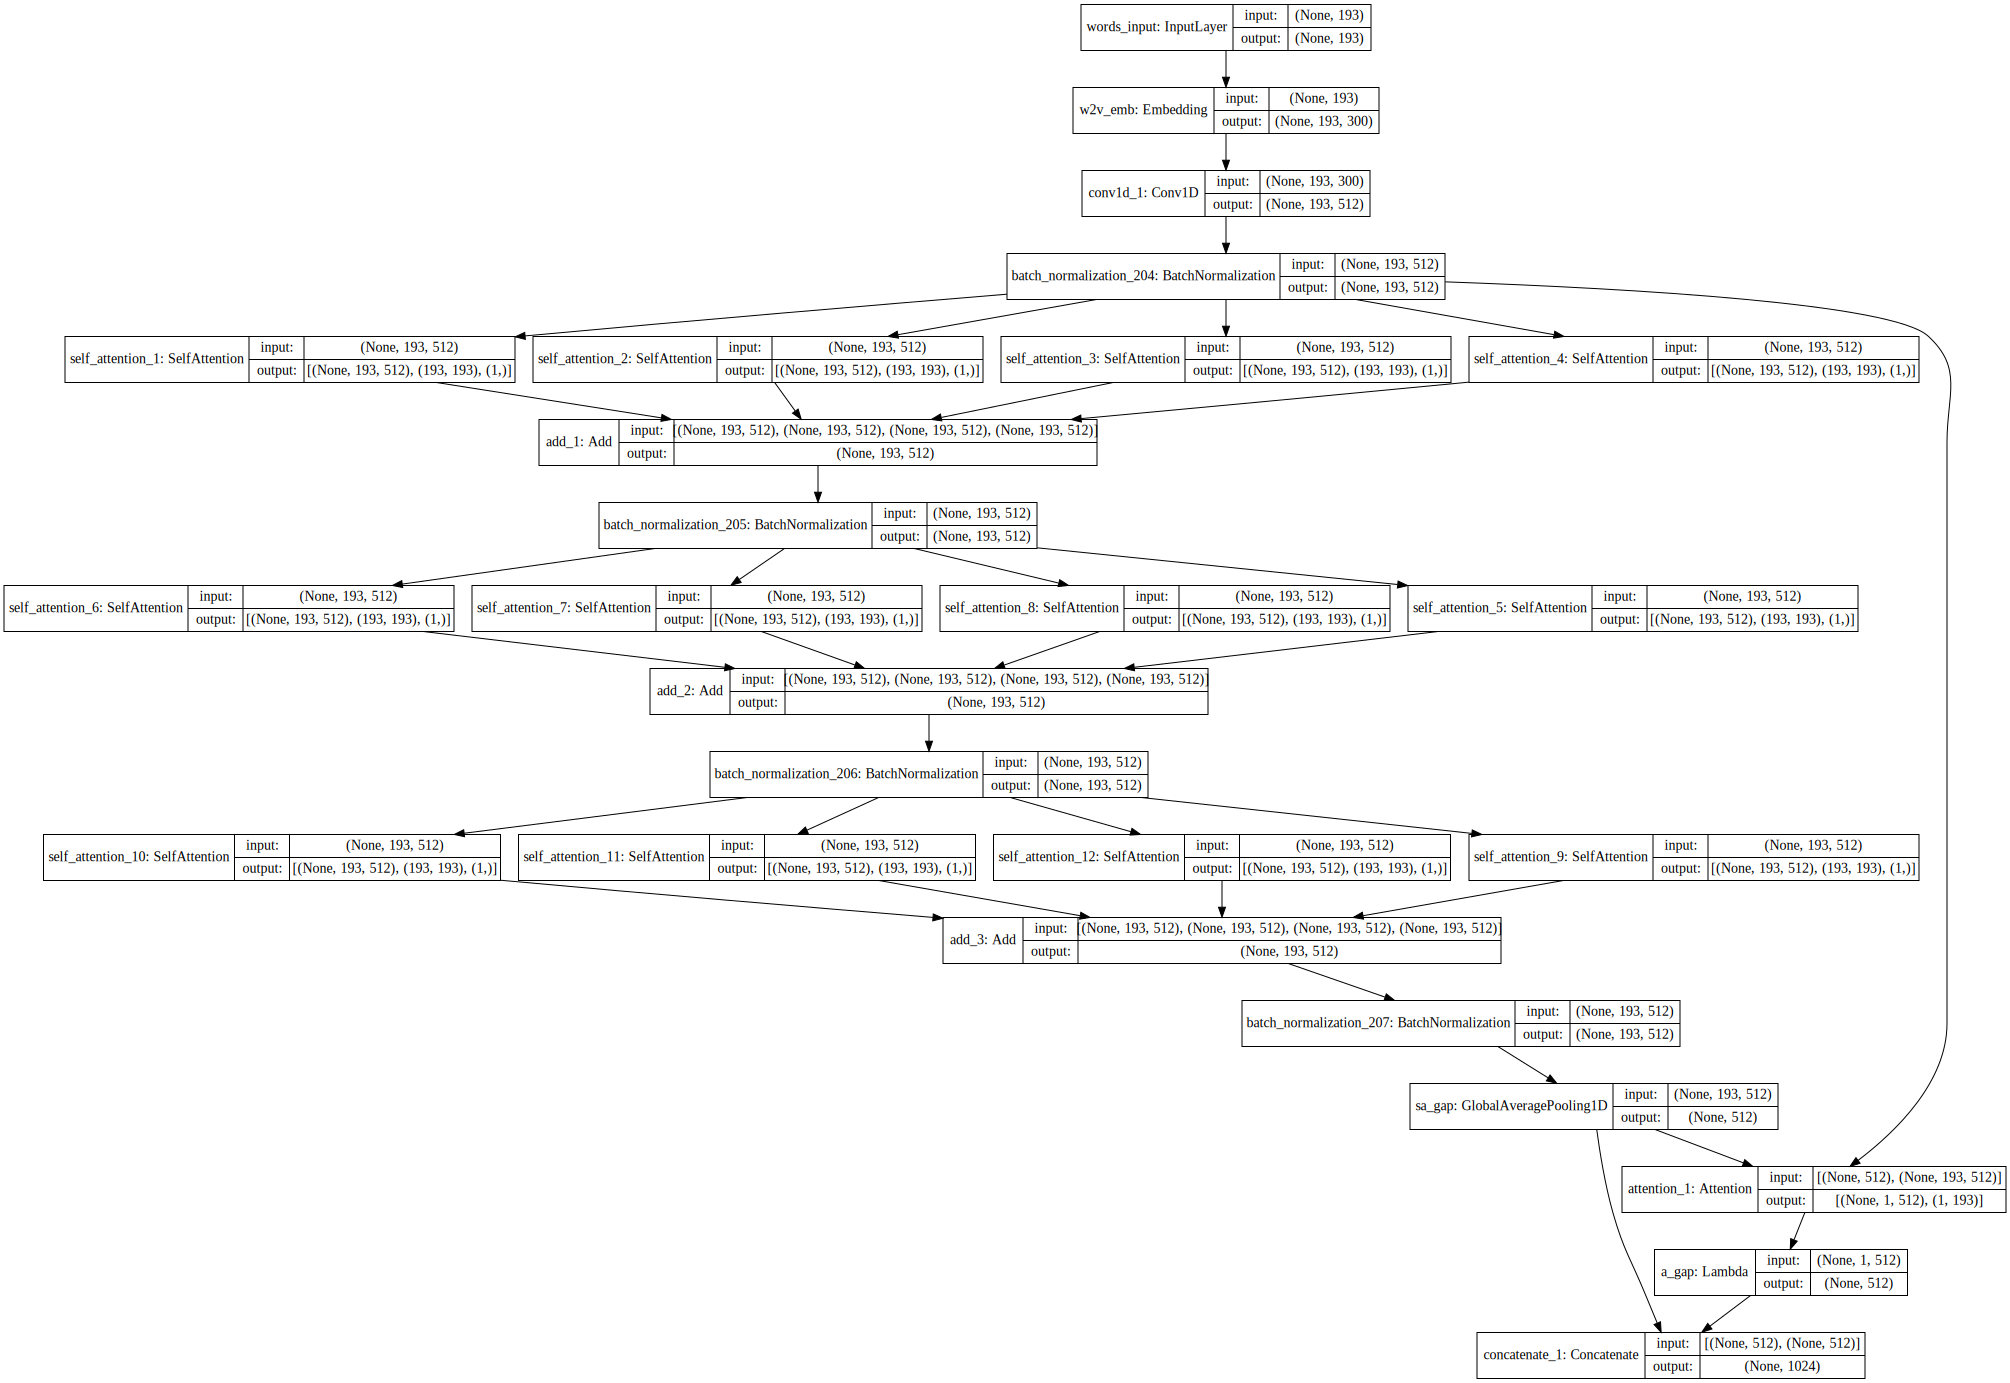

In [24]:
SVG(model_to_dot(textNet, show_layer_names=True, show_shapes=True).create(prog='dot', format='svg'))

# Define Complete Joint Network

In [25]:

image_input = Input(shape=(256,256,3),name='image_input')
image_features = imgNet(image_input)
image_features = kl.Dropout(0.1)(image_features)
image_features = kl.Flatten()(image_features)
image_features = kl.Dense(512,activation='relu')(image_features)

words_input = kl.Input(shape=(max_wlen,),name='words_input')
text_features = textNet(words_input)
text_features = kl.Dropout(0.1)(text_features)
text_features = kl.Dense(512,activation='relu')(text_features)

g = kl.Concatenate()([image_features,text_features])
g = kl.Dense(512, activation='relu')(g)
target = Dense(vocab_size+1, activation='softmax',name='target_word')(g)
model = Model([image_input,words_input],target)

q.shape,k.shape,v.shape, (?, 1, 64) (?, 193, 64) (?, 193, 512)


In [26]:
print('New model {0}. loading word2vec embeddings'.format(model_name))
l = textNet.get_layer('w2v_emb')
l.set_weights([embedding_matrix])
l.trainable = True
if not os.path.exists('../checkpoints/{0}.h5'.format(model_name)):
    print('New model {0}. loading word2vec embeddings'.format(model_name))
    l = textNet.get_layer('w2v_emb')
    l.set_weights([embedding_matrix])
    l.trainable = True
else:
    print('Existing model {0}. trained weights will be loaded'.format(model_name))
#     model.load_weights('../checkpoints/{0}.h5'.format(model_name))

New model irv2_1dcnn_attention_words. loading word2vec embeddings
Existing model irv2_1dcnn_attention_words. trained weights will be loaded


In [27]:
# w_to_co

In [28]:
model.summary()
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.0001,decay=1e-6),metrics=['accuracy'])


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
inception_resnet_v2 (Model)     (None, 6, 6, 1536)   54336736    image_input[0][0]                
__________________________________________________________________________________________________
words_input (InputLayer)        (None, 193)          0                                            
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 6, 6, 1536)   0           inception_resnet_v2[1][0]        
__________________________________________________________________________________________________
textModel 

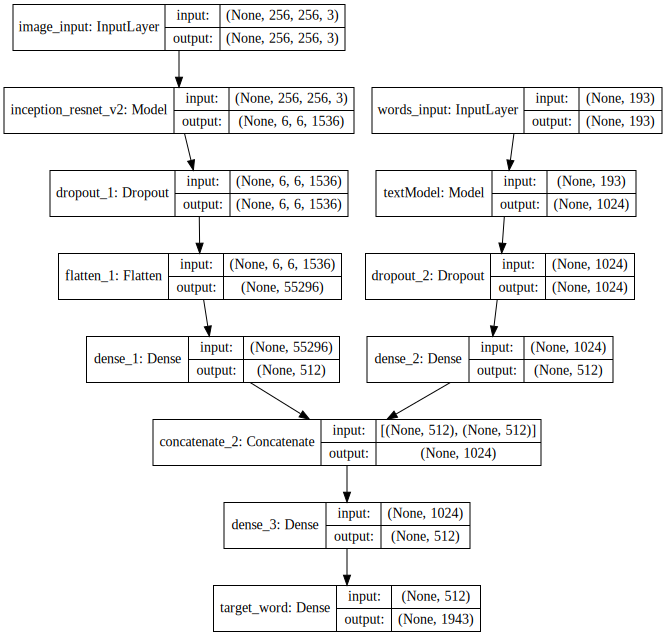

In [29]:
SVG(model_to_dot(model, show_layer_names=True, show_shapes=True).create(prog='dot', format='svg'))


In [30]:
model_json = model.to_json()
with open("../model_json/{0}.json".format(model_name), "w") as json_file:
    json_file.write(model_json)


In [31]:
emb = Model(textNet.inputs,textNet.get_layer('w2v_emb').output)
emb.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
words_input (InputLayer)     (None, 193)               0         
_________________________________________________________________
w2v_emb (Embedding)          (None, 193, 300)          582900    
Total params: 582,900
Trainable params: 582,900
Non-trainable params: 0
_________________________________________________________________


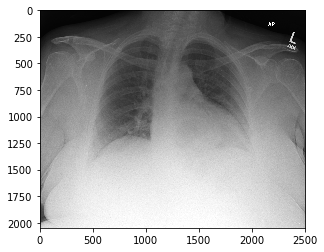

In [32]:
img = cv2.imread('../dataset/images/images_normalized/3591_IM-1770-1001-0001.dcm.png')
plt.imshow(img)

In [33]:
def datagen(img_lst,batch_size=4):
    counter=0
    x1,x2,y,sents = [],[],[],[]
    idx = 0
    while True:
        im = img_lst[idx]
        photo = cv2.imread('../dataset/images/images_normalized/resized_1024/{0}'.format(im))/255.0
        sent = merged_ds[merged_ds.filename==im]['findings'].values[0].lower().replace('/',' ')
        
        ts = nlp('startseq ' + sent + ' endseq')
#         print(ts)
        ts = [str(x) for x in list(ts)]
#         print(tss)
        sent_words = []
        for t in ts:
#             print(t)
#             t = 'sdadasasdasads'
            if (t not in w_to_co.keys()) : #or ('xx' in t):
#                 print('not present:',t)
                pass
            else:
                sent_words.append(t)
#         print(sent_words)
        seq = [w_to_co[x] for x in sent_words]
        # split one sequence into multiple X, y pairs
        for i in range(1, len(seq)):
            # split into input and output pair
            in_seq, out_seq = seq[:i], seq[i]
#             print(out_seq)
            in_seq = sequence.pad_sequences([in_seq], maxlen=max_wlen,padding='pre',value=0)[0]
            out_seq = np_utils.to_categorical([out_seq], num_classes=vocab_size+1)[0]
            x1.append(photo)
            x2.append(in_seq)
            y.append(out_seq)
            sents.append(sent)
        counter+=1
        idx+=1
#         print(idx)
        if idx==len(img_lst):
            idx=0
        if counter==batch_size:
            counter=0
            inputs = {'image_input': np.array(x1),
                      'words_input': np.array(x2)
                     }
            outputs = {'target_word':np.array(y),
                      'actual_sentence':np.array(sents)}
            yield inputs, outputs
            x1,x2,y,sents = [],[],[],[]

In [132]:


with open('../dataset/train_images.p', 'rb') as filehandle:
    # read the data as binary data stream
    train_images_list = pickle.load(filehandle)
with open('../dataset/val_images.p', 'rb') as filehandle:
    # read the data as binary data stream
    val_images_list = pickle.load(filehandle)
with open('../dataset/test_images.p', 'rb') as filehandle:
    # read the data as binary data stream
    test_images_list = pickle.load(filehandle)

print('train:',len(train_images_list),
      '+ val:',len(val_images_list),
      '+ test:',len(test_images_list),
      ' = ',(len(train_images_list)+len(val_images_list)+len(test_images_list)))
train_batch_size = 64
val_batch_size = 64
test_batch_size = 1
train_gen = datagen(train_images_list,batch_size=train_batch_size)
val_gen = datagen(val_images_list,batch_size=val_batch_size)
test_gen = datagen(test_images_list,batch_size=test_batch_size)

train: 5511 + val: 646 + test: 300  =  6457


In [122]:
# np.intersect1d(ar1=val_images_list,ar2=test_images_list)

array([3])

In [140]:
# imgs = merged_ds.filename.values
# np.random.shuffle(imgs)

# train_images_list = imgs[:int(0.7*len(imgs))]
# val_images_list = imgs[int(0.7*len(imgs)):int(0.8*len(imgs))]
# test_images_list = imgs[int(0.8*len(imgs)):]
# with open('../dataset/train_images.p', 'wb') as file:
#     # store the data as binary data stream
#     pickle.dump(train_images_list, file)
# with open('../dataset/val_images.p', 'wb') as file:
#     # store the data as binary data stream
#     pickle.dump(val_images_list, file)
# with open('../dataset/test_images.p', 'wb') as file:
#     # store the data as binary data stream
#     pickle.dump(test_images_list_r, file)
# with open('../dataset/chestxray_cnn_attention_decoder_ref_sents.p', 'wb') as file:
#     # store the data as binary data stream
#     pickle.dump(ref_sents, file)
# with open('../dataset/chestxray_cnn_attention_decoder_pred_sents.p', 'wb') as file:
#     # store the data as binary data stream
#     pickle.dump(pred_sents, file)


In [36]:
# tx,ty = next(train_gen)
# display(tx['image_input'].shape
#         ,tx['words_input'][30]
#         ,' '.join([co_to_w[x] if x !=0 else '' for x in tx['words_input'][30]])
#         ,ty['actual_sentence'][1])


In [38]:
# # def _ctc_lambda_func(args):
# #     labels, y_pred, input_length, label_length = args
# #     return K.tf.keras.backend.ctc_batch_cost(labels, y_pred, input_length, label_length)
# vggnet.summary()
# w_to_co['xxxx']

In [39]:
# print(co_to_w[1358])
# print(embedding_matrix[1380])

In [40]:
# emb_out = emb.predict(tx['words_input'])
# emb_out[1][-1]

In [41]:
# parallel_model=multi_gpu_model(model, gpus=4)

# parallel_model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.0001,decay=1e-06),metrics=['accuracy']) #For multi GPU
# parallel_model.summary()
# # model_resnet.summary()
# # parallel_model.load_weights('./../checkpoints/sa_vgg16_3d_32x24_m32_direct.h5', by_name=True, skip_mismatch=True)

In [125]:
# mc=ModelCheckpoint(filepath='../checkpoints/vgg16_lstm_words.h5',monitor='val_loss',period=1,save_best_only=True,save_weights_only=True,mode='auto',verbose=3)
# es=EarlyStopping(patience=300,monitor='val_loss',min_delta=0.0001,mode='auto')
print('training {0} for {1} epochs'.format(model_name,EPOCHS))

training irv2_1dcnn_attention_words for 10 epochs


2.0

In [127]:
from IPython.display import clear_output

# counter = 0
model.load_weights('../checkpoints/{0}.h5'.format(model_name))
# history = model.fit_generator(train_gen
#                               ,epochs=EPOCHS
#                               ,steps_per_epoch=4
#                               ,validation_data=val_gen
#                               ,validation_steps=2
#                               ,callbacks=[mc])

hist_tl,hist_ta,hist_vl,hist_va,tt = [],[],[],[],[]
window = 32
val_window = 128
train_iterations = int(np.ceil(len(train_images_list)/train_batch_size))
val_iterations = int(np.ceil(len(val_images_list)/val_batch_size))


min_v_l = 10
t_l, t_a, v_l, v_a = 0, 0, 2.4, 0
for e in tqdm_notebook(np.arange(start=0,stop=EPOCHS),desc='Epoch'):
    start_time = time()
    tl,ta,vl,va = [],[],[],[]
    for im in tqdm_notebook(range(train_iterations),desc='Train_Iter',leave=False):
        tx,ty = next(train_gen)
        inputs1 = tx['image_input']
        inputs2 = tx['words_input']
        labels = ty['target_word']        
        for i in np.arange(len(inputs1),step=window):
            loss,accuracy = model.train_on_batch([inputs1[i:i+window],inputs2[i:i+window]],labels[i:i+window])
            tl.append(loss)
            ta.append(accuracy)
    for im in tqdm_notebook(range(val_iterations),desc='Val_Iter',leave=False):
        vx,vy = next(val_gen)
        inputs1 = vx['image_input']
        inputs2 = vx['words_input']
        labels = vy['target_word']
        for i in np.arange(len(inputs1),step=val_window):
            loss,accuracy = model.evaluate(verbose=0,x=[inputs1[i:i+val_window],inputs2[i:i+val_window]],y=labels[i:i+val_window])
            vl.append(loss)
            va.append(accuracy)
    v_l = np.round(np.mean(vl),4)
    v_a = np.round(np.mean(va),4)
    t_l = np.round(np.mean(tl),4)
    t_a = np.round(np.mean(ta),4)
    
    hist_tl.append(t_l)
    hist_ta.append(t_a)
    hist_vl.append(v_l)
    hist_va.append(v_a)
    if v_l < min_v_l:
        min_v_l = v_l
        model.save_weights(filepath='../checkpoints/{0}.h5'.format(model_name),overwrite=True)
        imgNet.save_weights(filepath='../checkpoints/{0}_{1}_img_module.h5'.format(img_arch,text_arch),overwrite=True)
        textNet.save_weights(filepath='../checkpoints/{0}_{1}_text_module.h5'.format(img_arch,text_arch),overwrite=True)
    clear_output(wait=True)
    end_time = time()
    time_taken = end_time-start_time
    tt.append(time_taken)
    print('E:{0:3d}/{7}, tr_loss:{1:.4f}, tr_acc:{2:.4f}, v_loss:{3:.4f}, v_acc:{4:.4f} [{5:.2f} s/e] (min_v_loss:{6:.4f})'.format(e+1, t_l, t_a, v_l, v_a, np.mean(tt),min_v_l,EPOCHS))

E:  5/10, tr_loss:0.6760, tr_acc:0.8232, v_loss:3.5285, v_acc:0.4932 [4527.19 s/e] (min_v_loss:2.0567)


KeyboardInterrupt: 

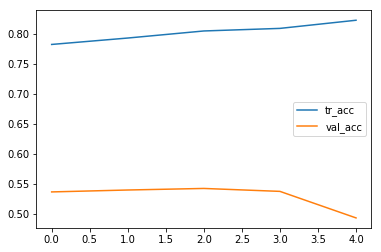

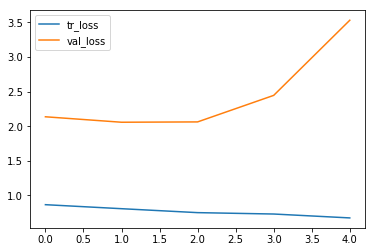

In [128]:
history = pd.DataFrame()
history['tr_acc'] = hist_ta
history['val_acc'] = hist_va
history['tr_loss'] = hist_tl
history['val_loss'] = hist_vl
display(history[['tr_acc','val_acc']].plot())
display(history[['tr_loss','val_loss']].plot())
history.to_csv('../tf_runs/{0}_1.csv'.format(model_name),index=False)

# Evaluate

In [129]:
model.load_weights('../checkpoints/{0}.h5'.format(model_name))

In [130]:

def predict_captions(image):
    start_word = ["startseq"]
    while True:
        par_caps = [w_to_co[i] for i in start_word]
        par_caps = sequence.pad_sequences([par_caps], maxlen=max_wlen, padding='pre',value=-1)
        preds = model.predict([image, np.array(par_caps)])
#         print(preds.shape)
        idx = preds.argmax(-1)
        word_pred = co_to_w[idx[0]]
#         print(par_caps)
        start_word.append(word_pred)
        
        if word_pred == "endseq" or len(start_word) > max_wlen:
            break
            
    return ' '.join(start_word[1:-1])

# print('Predicted:',' '.join(out_text))

In [131]:
def beam_search_predictions(image, beam_index = 3):
    start = [w_to_co["startseq"]]
    
    # start_word[0][0] = index of the starting word
    # start_word[0][1] = probability of the word predicted
    start_word = [[start, 0.0]]
    
    while len(start_word[0][0]) < max_wlen:
        temp = []
        for s in start_word:
            par_caps = sequence.pad_sequences([s[0]], maxlen=max_wlen, padding='pre', value=-1)
            preds = model.predict([image, np.array(par_caps)])
            
            # Getting the top <beam_index>(n) predictions
            word_preds = np.argsort(preds[0])[-beam_index:]
            
            # creating a new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]
    
    start_word = start_word[-1][0]
    intermediate_caption = [co_to_w[i] for i in start_word]

    final_caption = []
    
    for i in intermediate_caption:
        if i != 'endseq':
            final_caption.append(i)
        else:
            break
    
    final_caption = ' '.join(final_caption[1:])
    return final_caption

In [133]:
ref_sents = []
pred_sents = []
for counter in tqdm_notebook(range(len(test_images_list))):
    testx,testy = next(test_gen)
    photo = testx['image_input'][0]
#     plt.imshow(photo)
#     plt.show()
    photo = np.expand_dims(photo,0)
    
#     print('Actual:',testy['actual_sentence'][0])
#     print()
    # st = time()
    # pred_greedy = predict_captions(photo)
    # et = time()
    # print('Greedy Predicted:{0},[{1:.2f} s]'.format(pred_greedy,et-st))
#     st = time()
    pred_bm5 = beam_search_predictions(photo,beam_index=5)
#     et = time()
#     print('Beam-5 Predicted:{0},[{1:.2f} s]'.format(pred_bm5,et-st))
    ref_sents.append(testy['actual_sentence'][0])
    pred_sents.append(pred_bm5)

/home/mshaikh2/anaconda3/envs/tf-gpu/lib/python3.5/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


In [135]:
len(ref_sents),len(pred_sents)
# st = time()
# pred_greedy = predict_captions(photo)
# et = time()
# print('Greedy Predicted:{0},[{1:.2f} s]'.format(pred_greedy,et-st))

# st = time()
# pred_bm3 = beam_search_predictions(photo,beam_index=3)
# et = time()
# print('Beam-3 Predicted:{0},[{1:.2f} s]'.format(pred_bm3,et-st))

# st = time()
# pred_bm5 = beam_search_predictions(photo,beam_index=5)
# et = time()
# print('Beam-5 Predicted:{0},[{1:.2f} s]'.format(pred_bm5,et-st))

# st = time()
# pred_bm7 = beam_search_predictions(photo,beam_index=7)
# et = time()
# print('Beam-7 Predicted:{0},[{1:.2f} s]'.format(pred_bm7,et-st))



(300, 300)

In [136]:
from nltk.translate.bleu_score import sentence_bleu
from rouge import Rouge
rouge = Rouge()
# reference = nlp(str(vy['actual_sentence'][0]))
# reference = [[str(x) for x in list(reference)]]


# candidate = nlp(pred_greedy)
# candidate = [str(x) for x in list(candidate)]
# df_result['greedy'] = [sentence_bleu(reference, candidate, weights=(1, 0, 0, 0))
#                       ,sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0))
#                       ,sentence_bleu(reference, candidate, weights=(0.33, 0.33, 0.33, 0))
#                       ,sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25))]

# candidate = nlp(pred_bm3)
# candidate = [str(x) for x in list(candidate)]
# df_result['bm3'] = [sentence_bleu(reference, candidate, weights=(1, 0, 0, 0))
#                       ,sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0))
#                       ,sentence_bleu(reference, candidate, weights=(0.33, 0.33, 0.33, 0))
#                       ,sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25))]
row = []
for i in range(len(ref_sents)):
    r = ref_sents[i]
    c = pred_sents[i]
    reference = nlp(str(r))
    reference = [[str(x) for x in list(reference)]]
    candidate = nlp(str(c))
    candidate = [str(x) for x in list(candidate)]
    row.append([sentence_bleu(reference, candidate, weights=(1, 0, 0, 0))
                          ,sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0))
                          ,sentence_bleu(reference, candidate, weights=(0.33, 0.33, 0.33, 0))
                          ,sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25))
                          ,rouge.get_scores(hyps=c,refs=r)[0]['rouge-l']['f']])


# candidate = nlp(pred_bm7)
# candidate = [str(x) for x in list(candidate)]
# df_result['bm7'] = [sentence_bleu(reference, candidate, weights=(1, 0, 0, 0))
#                       ,sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0))
#                       ,sentence_bleu(reference, candidate, weights=(0.33, 0.33, 0.33, 0))
#                       ,sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25))]
df_result = pd.DataFrame(row)
df_result.columns = ['BLEU-1','BLEU-2','BLEU-3','BLEU-4','ROUGE-L']
df_result.round(3)

/home/mshaikh2/anaconda3/envs/tf-gpu/lib/python3.5/site-packages/nltk/translate/bleu_score.py:503: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/mshaikh2/anaconda3/envs/tf-gpu/lib/python3.5/site-packages/nltk/translate/bleu_score.py:503: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/mshaikh2/anaconda3/envs/tf-gpu/lib/python3.5/site-packages/nltk/translate/bleu_score.py:503: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Con

,BLEU-1,BLEU-2,BLEU-3,BLEU-4,ROUGE-L
0,0.368,0.173,0.000,0.000,0.226
1,0.310,0.222,0.161,0.120,0.290
2,0.361,0.144,0.000,0.000,0.372
3,0.500,0.414,0.360,0.301,0.468
4,0.469,0.301,0.212,0.158,0.314
5,0.277,0.126,0.000,0.000,0.333
6,0.500,0.308,0.202,0.146,0.385
7,0.161,0.000,0.000,0.000,0.059
8,0.500,0.349,0.242,0.000,0.500
9,0.487,0.277,0.187,0.115,0.436


In [137]:
p = df_result.round(3)
p.mean()

BLEU-1     0.354683
BLEU-2     0.205537
BLEU-3     0.122557
BLEU-4     0.062123
ROUGE-L    0.310510
dtype: float64

In [279]:
# pd.DataFrame(row)

In [171]:

# reference = str(vy['actual_sentence'][0])
# # reference = [[str(x) for x in list(reference)]]
# candidate = pred_greedy
# # candidate = [str(x) for x in list(candidate)]
# ro = rouge.get_scores(hyps=candidate,refs=reference)
ro

[{'rouge-1': {'f': 0.3544303756192918, 'p': 0.6086956521739131, 'r': 0.25},
  'rouge-2': {'f': 0.18181817773654926,
   'p': 0.3181818181818182,
   'r': 0.12727272727272726},
  'rouge-l': {'f': 0.42622950403654936,
   'p': 0.7222222222222222,
   'r': 0.3023255813953488}}]

In [73]:
pd.DataFrame(ro[0]).T

,f,p,r
rouge-1,0.354430,0.608696,0.250000
rouge-2,0.181818,0.318182,0.127273
rouge-l,0.426230,0.722222,0.302326


In [328]:
from pycocoevalcap.bleu.bleu import Bleu
from pycocoevalcap.rouge.rouge import Rouge
from pycocoevalcap.cider.cider import Cider
from pycocoevalcap.meteor.meteor import Meteor

In [191]:
def calc_scores(ref, hypo):
    """
    ref, dictionary of reference sentences (id, sentence)
    hypo, dictionary of hypothesis sentences (id, sentence)
    score, dictionary of scores
    """
    scorers = [
        (Bleu(4), ["Bleu_1", "Bleu_2", "Bleu_3", "Bleu_4"]),
#         (Meteor(),"METEOR"),
        (Rouge(), "ROUGE_L"),
        (Cider(), "CIDEr")
    ]
    final_scores = {}
    for scorer, method in scorers:
        score, scores = scorer.compute_score(ref, hypo)
        if type(score) == list:
            for m, s in zip(method, score):
                final_scores[m] = s
        else:
            final_scores[method] = score
    return final_scores 

In [277]:
r={}
h={}
df = pd.DataFrame(columns=['Bleu_1','Bleu_2','Bleu_3','Bleu_4','CIDEr','ROUGE_L'])
for i in range(len(ref_sents)):
#     t = nlp(str(ref_sents[i]))
#     t_arr = [[str(x) for x in t]]

    ref_t = nlp(str(ref_sents[i]))
    ref_t = [str(x) for x in ref_t]
    ref_t = ' '.join(ref_t)

    pred_t = nlp(str(pred_sents[i]))
    pred_t = [str(x) for x in pred_t]
    pred_t = ' '.join(pred_t)
    

    r['0']=[ref_t]
    h['0']=[pred_t]
    
    
    d = calc_scores(r,h)
    l = pd.DataFrame.from_dict(data=d,orient='index')
    l = l.sort_index()
    l = l.T
    df=df.append(l)

{'correct': [14, 3, 0, 0], 'reflen': 33, 'testlen': 38, 'guess': [38, 37, 36, 35]}
ratio: 1.1515151514802573
{'correct': [20, 10, 5, 3], 'reflen': 57, 'testlen': 36, 'guess': [36, 35, 34, 33]}
ratio: 0.6315789473573408
{'correct': [13, 2, 0, 0], 'reflen': 21, 'testlen': 36, 'guess': [36, 35, 34, 33]}
ratio: 1.7142857142040817
{'correct': [18, 12, 9, 6], 'reflen': 25, 'testlen': 36, 'guess': [36, 35, 34, 33]}
ratio: 1.4399999999424
{'correct': [15, 6, 3, 2], 'reflen': 32, 'testlen': 32, 'guess': [32, 31, 30, 29]}
ratio: 0.9999999999687501
{'correct': [20, 4, 0, 0], 'reflen': 63, 'testlen': 39, 'guess': [39, 38, 37, 36]}
ratio: 0.6190476190377929
{'correct': [19, 7, 3, 2], 'reflen': 33, 'testlen': 38, 'guess': [38, 37, 36, 35]}
ratio: 1.1515151514802573
{'correct': [5, 0, 0, 0], 'reflen': 19, 'testlen': 31, 'guess': [31, 30, 29, 28]}
ratio: 1.6315789472825484
{'correct': [19, 9, 4, 0], 'reflen': 37, 'testlen': 38, 'guess': [38, 37, 36, 35]}
ratio: 1.0270270269992696
{'correct': [19, 6, 3

{'correct': [11, 2, 1, 0], 'reflen': 37, 'testlen': 36, 'guess': [36, 35, 34, 33]}
ratio: 0.9729729729466765
{'correct': [22, 10, 6, 4], 'reflen': 49, 'testlen': 38, 'guess': [38, 37, 36, 35]}
ratio: 0.775510204065806
{'correct': [13, 5, 2, 1], 'reflen': 44, 'testlen': 32, 'guess': [32, 31, 30, 29]}
ratio: 0.7272727272561984
{'correct': [12, 2, 0, 0], 'reflen': 31, 'testlen': 36, 'guess': [36, 35, 34, 33]}
ratio: 1.161290322543184
{'correct': [18, 6, 3, 2], 'reflen': 54, 'testlen': 32, 'guess': [32, 31, 30, 29]}
ratio: 0.5925925925816187
{'correct': [21, 8, 3, 1], 'reflen': 75, 'testlen': 37, 'guess': [37, 36, 35, 34]}
ratio: 0.49333333332675555
{'correct': [14, 2, 1, 0], 'reflen': 40, 'testlen': 36, 'guess': [36, 35, 34, 33]}
ratio: 0.8999999999775001
{'correct': [10, 3, 1, 0], 'reflen': 19, 'testlen': 36, 'guess': [36, 35, 34, 33]}
ratio: 1.8947368420055402
{'correct': [10, 2, 1, 0], 'reflen': 20, 'testlen': 38, 'guess': [38, 37, 36, 35]}
ratio: 1.899999999905
{'correct': [16, 6, 2, 

{'correct': [14, 2, 0, 0], 'reflen': 33, 'testlen': 39, 'guess': [39, 38, 37, 36]}
ratio: 1.1818181817823692
{'correct': [18, 7, 3, 1], 'reflen': 35, 'testlen': 38, 'guess': [38, 37, 36, 35]}
ratio: 1.0857142856832653
{'correct': [14, 3, 1, 0], 'reflen': 45, 'testlen': 39, 'guess': [39, 38, 37, 36]}
ratio: 0.8666666666474074
{'correct': [22, 11, 7, 4], 'reflen': 40, 'testlen': 40, 'guess': [40, 39, 38, 37]}
ratio: 0.9999999999750001
{'correct': [14, 4, 2, 0], 'reflen': 27, 'testlen': 38, 'guess': [38, 37, 36, 35]}
ratio: 1.4074074073552811
{'correct': [16, 4, 0, 0], 'reflen': 48, 'testlen': 36, 'guess': [36, 35, 34, 33]}
ratio: 0.749999999984375
{'correct': [20, 8, 2, 1], 'reflen': 53, 'testlen': 32, 'guess': [32, 31, 30, 29]}
ratio: 0.6037735848942685
{'correct': [15, 3, 1, 0], 'reflen': 42, 'testlen': 34, 'guess': [34, 33, 32, 31]}
ratio: 0.8095238095045352
{'correct': [19, 7, 3, 1], 'reflen': 68, 'testlen': 36, 'guess': [36, 35, 34, 33]}
ratio: 0.5294117646980968
{'correct': [15, 5,

{'correct': [19, 7, 4, 2], 'reflen': 45, 'testlen': 36, 'guess': [36, 35, 34, 33]}
ratio: 0.7999999999822223
{'correct': [9, 3, 1, 0], 'reflen': 19, 'testlen': 36, 'guess': [36, 35, 34, 33]}
ratio: 1.8947368420055402
{'correct': [10, 3, 1, 0], 'reflen': 19, 'testlen': 36, 'guess': [36, 35, 34, 33]}
ratio: 1.8947368420055402
{'correct': [20, 6, 3, 1], 'reflen': 45, 'testlen': 38, 'guess': [38, 37, 36, 35]}
ratio: 0.8444444444256791
{'correct': [18, 6, 2, 0], 'reflen': 39, 'testlen': 36, 'guess': [36, 35, 34, 33]}
ratio: 0.9230769230532545
{'correct': [16, 8, 6, 4], 'reflen': 33, 'testlen': 36, 'guess': [36, 35, 34, 33]}
ratio: 1.0909090908760333
{'correct': [14, 4, 1, 0], 'reflen': 27, 'testlen': 36, 'guess': [36, 35, 34, 33]}
ratio: 1.3333333332839505
{'correct': [14, 1, 0, 0], 'reflen': 46, 'testlen': 36, 'guess': [36, 35, 34, 33]}
ratio: 0.7826086956351608
{'correct': [16, 7, 3, 1], 'reflen': 33, 'testlen': 38, 'guess': [38, 37, 36, 35]}
ratio: 1.1515151514802573
{'correct': [16, 1, 

In [280]:
df.mean()

Bleu_1     0.354704
Bleu_2     0.205565
Bleu_3     0.120703
Bleu_4     0.062119
CIDEr      0.000000
ROUGE_L    0.297629
dtype: float64

In [259]:
# sentence_bleu(references=[ref_sents[0]], hypothesis=pred_sents[0], weights=(1, 0, 0, 0))

In [231]:
[ref_sents[0]],pred_sents[0]

(['heart size within normal limits, stable mediastinal and hilar contours. no focal alveolar consolidation, no definite pleural effusion seen. no typical findings of pulmonary edema. no pneumothorax.'],
 'both lungs are clear bilaterally . specifically , no evidence of focal consolidation , pneumothorax , or pleural effusion . cardiomediastinal silhouette is unremarkable . visualized osseous structures appear intact . there are no acute bony abnormality .')

In [247]:
b = Bleu(4)

In [276]:
b.compute_score({'0':[ref_t]},{'0':[pred_t]})

{'correct': [14, 3, 0, 0], 'reflen': 33, 'testlen': 38, 'guess': [38, 37, 36, 35]}
ratio: 1.1515151514802573


([0.36842105262188374,
  0.17283511575720037,
  9.396955198772326e-07,
  2.206598690629072e-09],
 [[0.36842105262188374],
  [0.17283511575720037],
  [9.396955198772326e-07],
  [2.206598690629072e-09]])

In [266]:
sentence_bleu(references=[ref_sents[0].replace('.',' ').split()], hypothesis=pred_sents[0].replace('.',' ').split(), weights=(1, 0, 0, 0))

/home/mshaikh2/anaconda3/envs/tf-gpu/lib/python3.5/site-packages/nltk/translate/bleu_score.py:503: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/mshaikh2/anaconda3/envs/tf-gpu/lib/python3.5/site-packages/nltk/translate/bleu_score.py:503: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


0.2121212121212121

In [329]:
i=0
ref_t = nlp(str(ref_sents[i]))
ref_t = [str(x) for x in ref_t]
ref_t = ' '.join(ref_t)

pred_t = nlp(str(pred_sents[i]))
pred_t = [str(x) for x in pred_t]
pred_t = ' '.join(pred_t)


r['0']=[ref_t]
h['0']=[ref_t]

In [335]:
scorer = Cider(n=2)
scorer.compute_score(gts=r,res=h)

IndexError: list index out of range

In [319]:
r,h

({'0': ['heart size within normal limits , stable mediastinal and hilar contours . no focal alveolar consolidation , no definite pleural effusion seen . no typical findings of pulmonary edema . no pneumothorax .']},
 {'0': ['heart size within normal limits , stable mediastinal and hilar contours . no focal alveolar consolidation , no definite pleural effusion seen . no typical findings of pulmonary edema . no pneumothorax .']})